In [1]:
import numpy as np
import os

def read_lammps_dump(filename):
    """Reads a LAMMPS trajectory file and extracts box dimensions and atomic positions."""
    with open(filename, "r") as f:
        lines = f.readlines()

    frames = []
    i = 0
    while i < len(lines):
        if "ITEM: TIMESTEP" in lines[i]:
            timestep = int(lines[i + 1].strip())
            i += 2
        elif "ITEM: BOX BOUNDS" in lines[i]:
            # Read box bounds
            x_bounds = list(map(float, lines[i + 1].strip().split()))
            y_bounds = list(map(float, lines[i + 2].strip().split()))
            z_bounds = list(map(float, lines[i + 3].strip().split()))
            i += 4
        elif "ITEM: ATOMS" in lines[i]:
            # Read atomic data
            atom_data = []
            headers = lines[i].strip().split()[2:]  # Extract column names
            i += 1
            while i < len(lines) and "ITEM:" not in lines[i]:
                atom_data.append(list(map(float, lines[i].strip().split())))
                i += 1

            atom_data = np.array(atom_data)
            frames.append({
                "timestep": timestep,
                "box": (x_bounds, y_bounds, z_bounds),
                "atoms": atom_data,
                "headers": headers,
            })
        else:
            i += 1

    return frames


def write_vasp_file(frame, filename, atom_type_map, updated_counts):
    """Writes a single frame to a VASP POSCAR/CONTCAR file."""
    x_bounds, y_bounds, z_bounds = frame["box"]
    atoms = frame["atoms"]
    headers = frame["headers"]

    # Extract lattice vectors from box bounds
    a = x_bounds[1] - x_bounds[0]
    b = y_bounds[1] - y_bounds[0]
    c = z_bounds[1] - z_bounds[0]
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [0.0, b, 0.0],
        [0.0, 0.0, c],
    ])

    # Extract atom types and positions
    atom_types = atoms[:, headers.index("type")].astype(int)
    positions_cartesian = atoms[:, [headers.index("x"), headers.index("y"), headers.index("z")]]

    # Convert Cartesian coordinates to fractional
    inv_lattice = np.linalg.inv(lattice_vectors)
    positions_fractional = np.dot(positions_cartesian - [x_bounds[0], y_bounds[0], z_bounds[0]], inv_lattice)

    # Map numerical atom types to chemical symbols
    chemical_symbols = [atom_type_map[t] for t in atom_types]

    # Write VASP POSCAR/CONTCAR format with updated counts
    with open(filename, "w") as f:
        f.write(f"Generated from LAMMPS dump file\n")
        f.write(f"1.0\n")
        for vec in lattice_vectors:
            f.write(f"{vec[0]:.6f} {vec[1]:.6f} {vec[2]:.6f}\n")
        f.write(" ".join(updated_counts.keys()) + "\n")  # Chemical symbols
        f.write(" ".join(map(str, updated_counts.values())) + "\n")  # Updated counts
        f.write("Direct\n")
        
        for symbol in updated_counts.keys():
            count_to_write = updated_counts[symbol]
            symbol_positions = positions_fractional[np.array(chemical_symbols) == symbol]
            
            for pos in symbol_positions[:count_to_write]:
                f.write(f"{pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")


def convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts):
    """Converts all frames of a LAMMPS dump file to VASP POSCAR/CONTCAR files."""
    frames = read_lammps_dump(dump_file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, frame in enumerate(frames):
        filename = os.path.join(output_dir, f"CONTCAR{i+1}")
        write_vasp_file(frame, filename, atom_type_map, updated_counts)
        print(f"Saved: {filename}")


# Example usage
dump_file = "dump.nb"
output_dir = "vasp_files_1000"

# Define the mapping of numerical atom types to chemical symbols
atom_type_map = {
    1: "Mg",   # Atom type 1 -> Magnesium
    2: "V",    # Atom type 2 -> Oxygen
    3: "O",    # Atom type 3 -> Vanadium
}

# Define the updated counts for each chemical symbol (e.g., O -> 60)
updated_counts = {
    "Mg": 12,
    "V": 24,
    "O": 60,
}

convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts)


Saved: vasp_files_1000\CONTCAR1
Saved: vasp_files_1000\CONTCAR2
Saved: vasp_files_1000\CONTCAR3
Saved: vasp_files_1000\CONTCAR4
Saved: vasp_files_1000\CONTCAR5
Saved: vasp_files_1000\CONTCAR6
Saved: vasp_files_1000\CONTCAR7
Saved: vasp_files_1000\CONTCAR8
Saved: vasp_files_1000\CONTCAR9
Saved: vasp_files_1000\CONTCAR10
Saved: vasp_files_1000\CONTCAR11
Saved: vasp_files_1000\CONTCAR12
Saved: vasp_files_1000\CONTCAR13
Saved: vasp_files_1000\CONTCAR14
Saved: vasp_files_1000\CONTCAR15
Saved: vasp_files_1000\CONTCAR16
Saved: vasp_files_1000\CONTCAR17
Saved: vasp_files_1000\CONTCAR18
Saved: vasp_files_1000\CONTCAR19
Saved: vasp_files_1000\CONTCAR20
Saved: vasp_files_1000\CONTCAR21
Saved: vasp_files_1000\CONTCAR22
Saved: vasp_files_1000\CONTCAR23
Saved: vasp_files_1000\CONTCAR24
Saved: vasp_files_1000\CONTCAR25
Saved: vasp_files_1000\CONTCAR26
Saved: vasp_files_1000\CONTCAR27
Saved: vasp_files_1000\CONTCAR28
Saved: vasp_files_1000\CONTCAR29
Saved: vasp_files_1000\CONTCAR30
Saved: vasp_files_1

In [2]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files_50ps"
vasp_dir = r"E:\2_4_6\1200\vasp_files_1000"


# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert all CONTCAR files to pymatgen Structures
structures = []
for contcar_file in contcar_files:
    # Read the VASP file using ASE
    atoms = read(contcar_file)
    
    # Extract data from ASE Atoms object
    species = atoms.get_chemical_symbols()  # Atomic species
    positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
    lattice = atoms.get_cell()              # Lattice vectors (simulation box)
    
    # Convert to pymatgen Structure object
    structure = Structure(lattice, species, positions)
    structures.append(structure)

    print(f"Loaded structure from: {contcar_file}")

# Print summary
print(f"Number of structures loaded: {len(structures)}")


Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR1
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR10
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR100
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR1000
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR1001
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR101
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR102
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR103
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR104
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR105
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR106
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR107
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR108
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR109
Loaded structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR11
Loaded structure from: E:\2_4_6\1200\vasp_

In [3]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files"

# Define the output directory for filtered structures
#output_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\filtered_vasp_files_50ps"
output_dir = r"E:\2_4_6\1200\fileterd_vasp_files_1200K"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert every 10th CONTCAR file to pymatgen Structures and save to a new folder
structures = []
for i, contcar_file in enumerate(contcar_files):
    if i % 10== 0:  # Process every 10th structure
        # Read the VASP file using ASE
        atoms = read(contcar_file)
        
        # Extract data from ASE Atoms object
        species = atoms.get_chemical_symbols()  # Atomic species
        positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
        lattice = atoms.get_cell()              # Lattice vectors (simulation box)
        
        # Convert to pymatgen Structure object
        structure = Structure(lattice, species, positions)
        structures.append(structure)

        # Save the structure as a new CONTCAR file in the output directory
        output_file = os.path.join(output_dir, f"CONTCAR_{i+1}")
        structure.to(filename=output_file, fmt="poscar")  # Save as POSCAR/CONTCAR format
        
        print(f"Processed and saved structure from: {contcar_file} to {output_file}")

# Print summary of filtered structures
print(f"Number of structures saved: {len(structures)}")


C:\Users\DEBS\AppData\Roaming\Python\Python311\site-packages\pymatgen\io\vasp\inputs.py:660: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="wt") as file:


Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR1 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_1
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR106 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_11
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR115 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_21
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR124 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_31
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR133 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_41
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR142 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_51
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR151 to E:\2_4_6\1200\fileterd_vasp_files_1200K\CONTCAR_61
Processed and saved structure from: E:\2_4_6\1200\vasp_files_1000\CONTCAR160 to E:\2_4

In [4]:
from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer

# Perform diffusion analysis on the loaded structures
diff_analyzer = DiffusionAnalyzer.from_structures(
    structures=structures,  # Your list of pymatgen Structure objects
    specie="Mg",            # The species for which you want to analyze diffusion
    temperature=300,        # Temperature in Kelvin
    time_step=1.5,            # Time step between frames in femtoseconds
    step_skip=100000,         # Skip every 1000 steps for smoother analysis
    smoothed="constant",    # Smoothing method (can also be "max")
    avg_nsteps=70 # Number of steps for averaging (smaller window for finer resolution)
)

# # Print diffusivity and other properties
# print(f"Diffusivity: {diff_analyzer.diffusivity} cm^2/s")
# print(f"Mean squared displacement (MSD):\n{diff_analyzer.msd}")
# print(f"Vacancy corrected diffusivity: {diff_analyzer.vacancy_corrected_diffusivity} cm^2/s")


AttributeError: 'Axes' object has no attribute 'show'

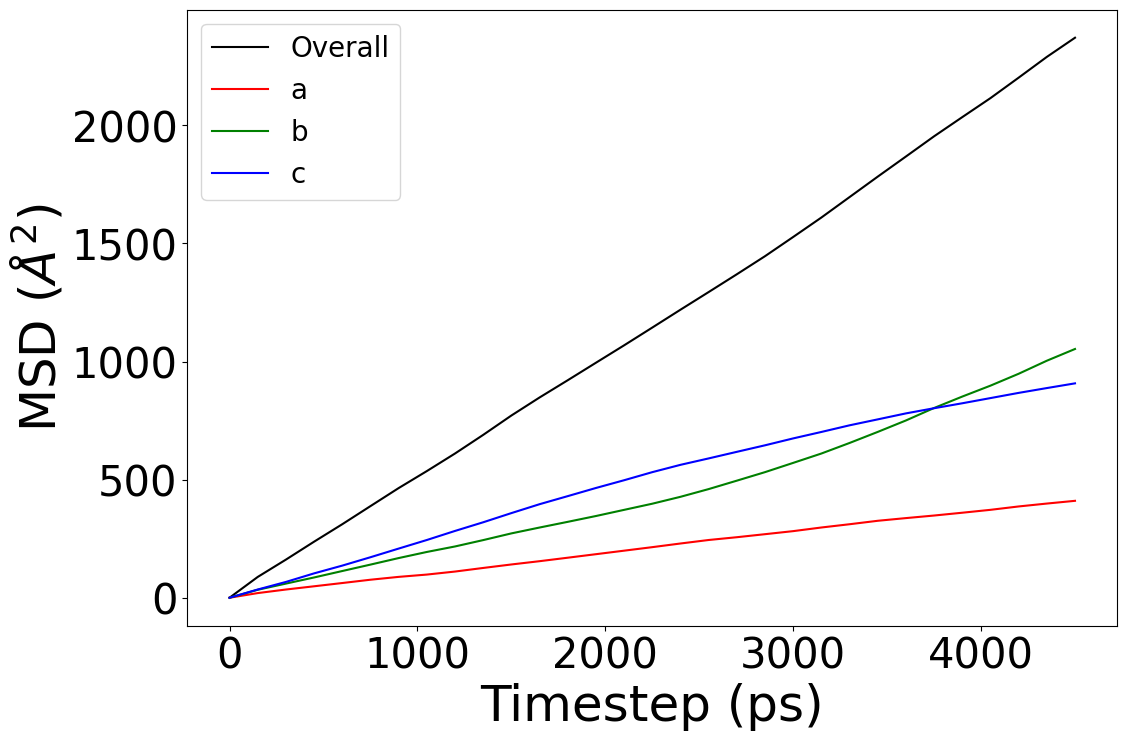

In [5]:
# Plot the smoothed MSD vs. time graph
diff_analyzer.plot_msd(mode="site")  # Default mode plots MSD for all directions combined

In [6]:
diff_analyzer.get_summary_dict(include_msd_t=False, include_mscd_t=False)

{'D': 8.694816048947995e-06,
 'D_sigma': 3.979772438410081e-08,
 'D_charge': 9.1297779002778e-06,
 'D_charge_sigma': 1.569904397420567e-07,
 'S': 293.80611071441,
 'S_sigma': 1.3448029895918772,
 'S_charge': 308.503885702279,
 'D_components': [4.566571414691319e-06,
  1.1187961807055921e-05,
  1.0329914925096746e-05],
 'S_components': [154.3087949298699, 378.0518790561619, 349.0576581571983],
 'D_components_sigma': [2.27637725049295e-08,
  3.047741814851479e-07,
  1.751177932596858e-07],
 'S_components_sigma': [0.7692095413186081,
  10.298609700794445,
  5.917396925348816],
 'specie': 'Mg',
 'step_skip': 100000,
 'time_step': 1.5,
 'temperature': 300,
 'max_framework_displacement': 155.30910331724246,
 'Haven_ratio': 0.9523578934689562}

C:\Users\DEBS\AppData\Local\Temp\ipykernel_28380\2420837355.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


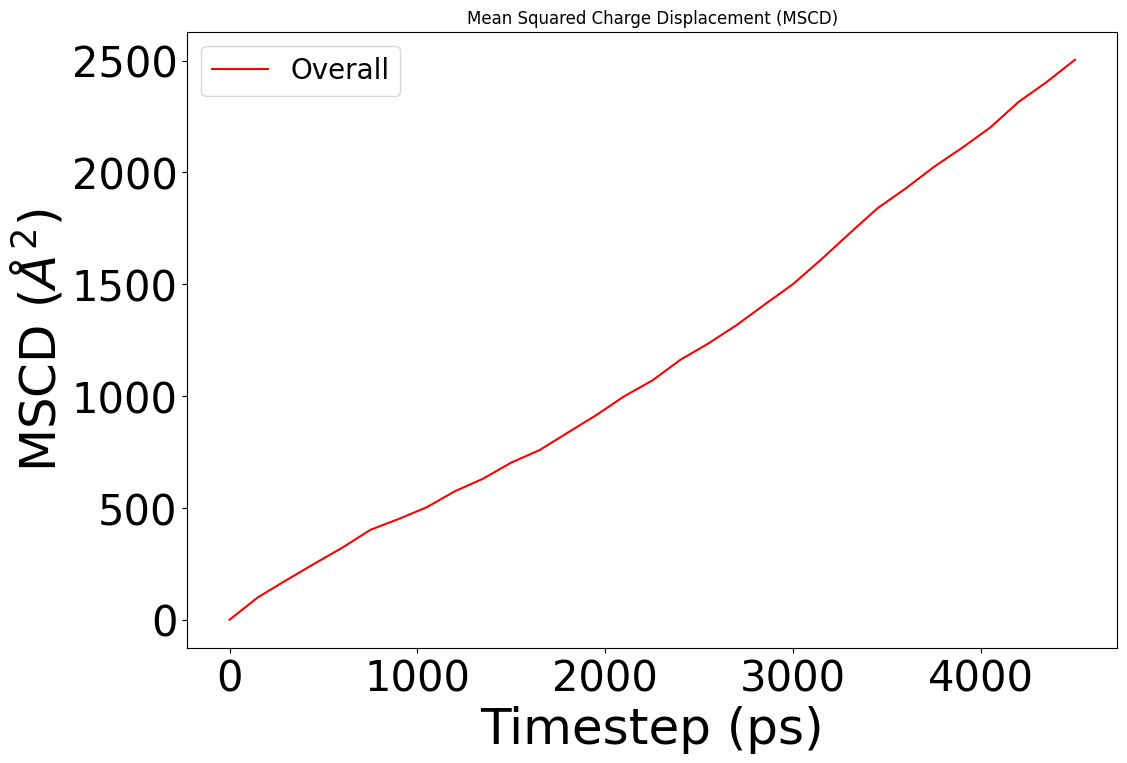

In [7]:
# Plot MSCD
ax = diff_analyzer.get_msd_plot(mode="mscd")
ax.set_title("Mean Squared Charge Displacement (MSCD)")
ax.figure.show()


In [9]:

#diff_calc.plot_msd(mode='default')
diff_analyzer.export_msdt("md_50ps")
import os
import pandas as pd
msd_md = pd.read_table("md_50ps", delimiter=' ')
print(msd_md)

            #            t         MSD        MSD_a       MSD_b        MSD_c  \
0         0.0     0.000000    0.000000     0.000000    0.000000     0.000000   
1    150000.0    88.013825   19.622596    33.618594   34.772635    99.571696   
2    300000.0   161.358856   34.707928    59.791366   66.859563   175.712088   
3    450000.0   237.311618   48.446981    85.788045  103.076592   249.821470   
4    600000.0   311.237053   62.212665   113.065994  135.958393   322.078028   
5    750000.0   387.873082   76.203827   140.232743  171.436512   402.005246   
6    900000.0   464.199407   88.264531   167.883584  208.051292   450.359437   
7   1050000.0   536.148233   98.017888   193.754986  244.375360   503.144839   
8   1200000.0   610.566980  110.797652   217.018059  282.751268   574.572551   
9   1350000.0   689.459571  126.039434   243.980645  319.439491   630.897750   
10  1500000.0   771.412314  140.793577   272.347547  358.271190   702.898202   
11  1650000.0   847.786842  154.660276  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']
time = time_fs / 1000  # Convert time to ps

# Perform cumulative sum with a step of 700 for MSCD (Mean Squared Charge Displacement)
MSCD = msd_dft['MSD_c']  # MSCD calculation
msd_t = msd_dft['t']  # 't' values (time steps)

# Adjust the time array to match the reduced points
time_reduced = time

# Linear regression to calculate slope (for diffusivity calculation)
slope, intercept, r_value, p_value, std_err = stats.linregress(time_reduced, MSCD)

# Calculate diffusivity (MSCD)
diff_coeff_ang = slope / 6  # Diffusion coefficient in Å^2/ps
diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s

# Plotting MSCD vs Time
legend_properties = {'weight': 'bold', 'size': 14}
fig, ax = plt.subplots(figsize=(8, 6))

# Plot MSCD (data points)
ax.plot(time_reduced, MSCD, 'ro', markersize=6, label='Data Points')  # Red dots for data points

# Plot linear regression line
ax.plot(time_reduced, intercept + slope * time_reduced, color='k', label='Linear Fit', linewidth=1)

# Set x-axis limit to 30 ps
plt.xlim(0, 2000)


# Axis labels and legend
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')
plt.xlim(0, 4000)
plt.ylim(0, 2500)
#plt.ylim(0, 6)

# Show the plot
plt.tight_layout()

# Save the figure as PDF
plt.savefig("dd_mscd_30ps.pdf", format='pdf')

# Display the plot
plt.show()

# Print the calculated diffusivity
print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import stats

# # Assuming msd_dft is already loaded as a DataFrame
# time_fs = msd_dft['#']
# time = time_fs / 1000  # Convert time to ps

# # Perform cumulative sum with a step of 700
# msd_a = msd_dft['MSD'][::1450].cumsum()
# msd_b = msd_dft['MSD_a'][::1450].cumsum()
# msd_c = msd_dft['MSD_b'][::1450].cumsum()
# msd_t = msd_dft['t'][::1450].cumsum()

# # Adjust the time array to match the reduced points
# time_reduced = time[::1450]

# # Linear regression to calculate slope
# slope, intercept, r_value, p_value, std_err = stats.linregress(time_reduced, msd_t)

# # Calculate diffusivity
# diff_coeff_ang = slope / 6  # Diffusion coefficient in Å^2/ps
# diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s

# # Plotting
# legend_properties = {'weight': 'bold', 'size': 14}
# fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(time_reduced, msd_a, linewidth=4, linestyle='-', color='b', label='a')
# ax.plot(time_reduced, msd_b, linewidth=4, linestyle='dashdot', color='g', label='b')
# ax.plot(time_reduced, msd_c, linewidth=4, linestyle='--', color='m', label='c')
# ax.plot(time_reduced, msd_t, linewidth=4, linestyle='dotted', color='r', label='overall')
# ax.plot(time_reduced, intercept + slope * time_reduced, color='k', label='Linear Fit', linewidth=1)

# # Set x-axis limit to 30 ps
# plt.xlim(0, 30)
# plt.ylim(0, 4)

# # Axis labels and legend
# ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
# ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
# ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# # Adjust axis line widths
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(1.8)

# # Set ticks and styles
# plt.xticks(weight='bold', fontsize=14)
# plt.yticks(weight='bold', fontsize=14)
# plt.tick_params(direction='in')

# # Show the plot
# plt.tight_layout()

# # Save the figure as PDF
# plt.savefig("dd_all_30ps.pdf", format='pdf')

# # Display the plot
# plt.show()

# # Print the calculated diffusivity
# print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
# print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")


In [ ]:
import os
import pandas as pd

# Load the data from the file
msd_dft = pd.read_table("md_50ps", delimiter=' ')

# Check the shape of the DataFrame to get the number of time steps (rows)
num_time_steps = msd_dft.shape[0]

# Print the number of time steps
print(f"Number of time steps: {num_time_steps}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
msd_dft = pd.read_csv("md_50ps", delimiter=' ')  # Adjust the file path if needed

# Extract time and MSCD (Mean Squared Charge Displacement)
time = msd_dft['t'] / 1000  # Convert time to ps
MSCD = msd_dft['MSCD']  # MSCD (Mean Squared Charge Displacement)

# Initialize an empty list to store TMSD values
tmsd_values = []

# Loop through different delta t values (starting from 0.001 ps to the last delta t)
for delta_t in range(150, 150 * (len(time)-1), 150):  # delta_t steps with 150 ps increments
    msd_delta_t = []

    # Loop through all valid t values
    for t_start in range(len(time) - delta_t):
        # Calculate the squared displacement for each interval of delta_t
        displacement = np.mean(np.square(MSCD[t_start + delta_t] - MSCD[t_start]))
        msd_delta_t.append(displacement)

    # Calculate the average MSD for this delta_t and append to TMSD list
    tmsd_values.append(np.mean(msd_delta_t))

# Convert delta_t values to time steps (in ps)
delta_t_values = [150 * (i+1) for i in range(len(tmsd_values))]  # 150, 300, 450, ...

# Plotting MSD vs delta_t
plt.figure(figsize=(8, 6))
plt.plot(delta_t_values, tmsd_values, marker='o', linestyle='-', color='b', label='TMSD vs Δt')

# Labels and title
plt.xlabel('Δt (ps)', fontsize=14)
plt.ylabel('TMSD (MSCD) (Å^2)', fontsize=14)
plt.title('Total Mean Squared Displacement (TMSD) vs Time Interval (Δt)', fontsize=16)

# Show the plot
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and TMSD (averaged MSCD values)
delta_t_values = []
TMSD_values = []

# Loop over different values of delta_t (from 0 to max time)
for i in range(len(time)):
    # Calculate delta_t (time difference from the current time point to the starting time)
    delta_t = time[i] - time[0]
    if delta_t == 0:  # Skip delta_t = 0 as it's not useful for averaging
        continue

    # Average MSCD over a time window of delta_t (i.e., average the MSD for this delta_t)
    avg_mscd = np.mean(MSCD[:i + 1])  # Average all MSCD values up to this point
    delta_t_values.append(delta_t)
    TMSD_values.append(avg_mscd)

# Print the delta_t and corresponding TMSD values
print("Delta t values:", delta_t_values)
print("TMSD values:", TMSD_values)

# Plotting MSCD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, TMSD_values, 'bo-', markersize=6, label="MSCD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)
plt.xlim(0, max(delta_t_values))  # Set x-axis limits to the range of delta_t
plt.ylim(0, max(TMSD_values))  # Adjust y-axis limit as per the range of MSCD

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and TMSD (averaged MSCD values)
delta_t_values = []
TMSD_values = []

# Loop over different values of delta_t (starting from 0 ps to max time)
for i in range(1, len(time)):  # Start from 1 to avoid delta_t = 0
    delta_t = time[i] - time[0]  # Calculate delta_t as the difference from the first time point
    
    # Calculate the number of points to average for this delta_t
    num_points = i  # Since delta_t is increasing, we average the first i points
    
    # Average MSCD for the first num_points points
    avg_mscd = np.mean(MSCD[:num_points])
    
    delta_t_values.append(delta_t)
    TMSD_values.append(avg_mscd)

# Print the delta_t and corresponding TMSD values
print("Delta t values:", delta_t_values)
print("TMSD values:", TMSD_values)

# Plotting MSCD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, TMSD_values, 'bo-', markersize=6, label="MSCD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits to ensure it doesn't go beyond expected range
plt.xlim(0, 3000)  # Adjust according to the range of delta_t
plt.ylim(0, max(TMSD_values))  # Adjust y-axis limit to the max TMSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and TMSD (averaged MSCD values)
delta_t_values = []
TMSD_values = []

# Loop over the time array and compute averages as per your logic
for i in range(len(time)):
    # Calculate delta_t as the difference from the first time point
    delta_t = time[i] - time[0]
    
    if delta_t == 0:  # For delta_t = 0, we don't want to average, just plot as 0, 0
        delta_t_values.append(0)
        TMSD_values.append(0)
    else:
        # Determine how many points to average for this delta_t
        # We average over the first 'i' points for time[i]
        num_points = min(i + 1, 30)  # Ensure that the number of points does not exceed 30
        avg_mscd = np.mean(MSCD[:num_points])
        
        delta_t_values.append(delta_t)
        TMSD_values.append(avg_mscd)

# Print the delta_t and corresponding TMSD values
print("Delta t values:", delta_t_values)
print("TMSD values:", TMSD_values)

# Plotting MSCD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, TMSD_values, 'bo-', markersize=6, label="MSCD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(TMSD_values))  # Adjust y-axis limit to the max TMSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and TMSD (averaged MSCD values)
delta_t_values = []
TMSD_values = []

# Loop over the time array and compute averages as per your logic
for i in range(len(time)):
    # Calculate delta_t as the difference from the first time point
    delta_t = time[i] - time[0]
    
    if delta_t == 0:  # For delta_t = 0, we don't want to average, just plot as 0, 0
        delta_t_values.append(0)
        TMSD_values.append(0)
    else:
        # Calculate the number of points to average for this delta_t
        # For 150 ps -> 30 points, 300 ps -> 29 points, etc.
        num_points = 30 - (i // (len(time) // 30))  # This logic reduces the number of points as delta_t increases
        
        # Average MSCD over the first num_points
        avg_mscd = np.mean(MSCD[:i + 1])
        
        delta_t_values.append(delta_t)
        TMSD_values.append(avg_mscd)

# Print the delta_t and corresponding TMSD values
print("Delta t values:", delta_t_values)
print("TMSD values:", TMSD_values)

# Plotting MSCD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, TMSD_values, 'bo-', markersize=6, label="MSCD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(TMSD_values))  # Adjust y-axis limit to the max TMSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = [0]  # Starting with 0
MSD_values = [0]  # Starting with 0

# Define how many points to average at each step
avg_points = 30
max_time = len(time)

# Loop over delta_t values (150, 300, 450, etc.)
for i in range(avg_points, max_time, avg_points):
    delta_t = time[i]  # Delta t corresponds to the last time point in the averaged window
    
    # Calculate the average MSD over the last `avg_points` values
    avg_msd = np.mean(MSCD[i - avg_points:i])
    
    delta_t_values.append(delta_t)
    MSD_values.append(avg_msd)

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(MSD_values))  # Adjust y-axis limit to the max MSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = [0]  # Starting with 0
MSD_values = [0]  # Starting with 0

# Define how many points to average at each step
avg_points = 30
max_time = len(time)

# Loop over delta_t values (150, 300, 450, etc.)
for i in range(avg_points, max_time, avg_points):
    delta_t = time[i]  # Delta t corresponds to the last time point in the averaged window
    
    # Calculate the average MSD over the last `avg_points` values
    avg_msd = np.mean(MSCD[i - avg_points:i])
    
    delta_t_values.append(delta_t)
    MSD_values.append(avg_msd)

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Calculate the slope using linear regression
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_values)

# Print the slope
print(f"Slope of the MSD vs Delta t plot: {slope}")

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Plot the


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = [0]  # Starting with 0
MSD_values = [0]  # Starting with 0

# Define how many points to average at each step
avg_points = 30
max_time = len(time)

# Loop over delta_t values (150, 300, 450, etc.)
for i in range(avg_points, max_time, avg_points):
    delta_t = time[i]  # Delta t corresponds to the last time point in the averaged window
    
    # Calculate the average MSD over the last `avg_points` values
    avg_msd = np.mean(MSCD[i - avg_points:i])
    
    delta_t_values.append(delta_t)
    MSD_values.append(avg_msd)

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Calculate the slope using linear regression
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_values)

# Calculate diffusivity using the formula: diffusivity = slope / 6 * 10^-4
diffusivity_ang = slope / 6  # Diffusivity in Å²/ps
diffusivity_cm = diffusivity_ang * 1e-4  # Convert to cm²/s

# Print the calculated diffusivity
print(f"Slope of the MSD vs Delta t plot: {slope}")
print(f"Diffusivity (Å²/ps): {diffusivity_ang:.6f}")
print(f"Diffusivity (cm²/s): {diffusivity_cm:.6e}")

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Plot the linear fit (best-fit line)
ax.plot(delta_t_values, intercept + slope * np.array(delta_t_values), 'r--', label="Linear fit")

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(MSD_values))  # Adjust y-axis limit to the max MSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = [0]  # Starting with 0
MSD_values = [0]  # Starting with 0

# Define how many points to average at each step
avg_points = 30
max_time = len(time)

# Loop over delta_t values (150, 300, 450, etc.)
for i in range(avg_points, max_time, avg_points):
    delta_t = time[i]  # Delta t corresponds to the last time point in the averaged window
    
    # Calculate the average MSD over the last `avg_points` values
    avg_msd = np.mean(MSCD[i - avg_points:i])
    
    delta_t_values.append(delta_t)
    MSD_values.append(avg_msd)

# Handle the last point (where you have only one point to average)
delta_t_values.append(time.iloc[-1])  # Last time point (e.g., 4000 ps)
MSD_values.append(MSCD.iloc[-1])  # Actual MSD at the last point (no averaging)

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(MSD_values))  # Adjust y-axis limit to the max MSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = []  # Will hold delta_t values (e.g., 150, 300, ...)
MSD_values = []  # Will hold averaged MSD values

# Define how many points to average at each step (e.g., 150 ps, 300 ps, etc.)
avg_points = 150  # Start with 150 ps as the delta_t
max_time = len(time)

# Loop through delta_t values (150, 300, 450, etc.)
for delta_t in range(avg_points, max_time, avg_points):
    msd_list = []  # List to store averaged MSD for each delta_t
    
    # Calculate MSD for each segment of size delta_t
    for start in range(0, max_time - delta_t + 1, avg_points):
        end = start + delta_t  # Define the end point for the segment
        msd_segment = MSCD[start:end]  # Get the MSD values for this segment
        msd_avg = np.mean(msd_segment)  # Average the MSD for this segment
        msd_list.append(msd_avg)
    
    # Average the MSD values for this delta_t
    avg_msd = np.mean(msd_list)
    
    # Store the delta_t and corresponding averaged MSD
    delta_t_values.append(delta_t)
    MSD_values.append(avg_msd)

# Handle the last point where there may not be enough data points
delta_t_values.append(time.iloc[-1])  # Last time point (e.g., 4000 ps)
MSD_values.append(MSCD.iloc[-1])  # MSD at the last time point (no averaging)

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(MSD_values))  # Adjust y-axis limit to the max MSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time = time_fs / 1000  # Convert to picoseconds (ps)
MSCD = msd_dft['MSD_c']  # Mean Squared Charge Displacement (MSCD)

# Initialize lists to store delta_t and corresponding MSD values
delta_t_values = []  # Will hold delta_t values (e.g., 150, 300, ...)
MSD_values = []  # Will hold averaged MSD values

# Define the time intervals you want to use (150, 300, etc.)
delta_ts = [150, 300, 4500]  # Your delta_t values

# Loop over each delta_t value and calculate the MSDs
for delta_t in delta_ts:
    msd_list = []  # List to store MSD values for this delta_t
    
    # For delta_t = 150, 300, ..., we calculate MSD values by averaging over time windows
    for start in range(0, len(time) - delta_t, delta_t):
        end = start + delta_t  # Ensure we don't exceed the time array length
        
        # Get the MSD values for this segment and calculate the average
        msd_segment = MSCD[start:end]
        msd_avg = np.mean(msd_segment)  # Calculate average MSD for the current segment
        
        msd_list.append(msd_avg)
    
    # Calculate the final average MSD for this delta_t (mean of all segments)
    delta_t_values.append(delta_t)
    MSD_values.append(np.mean(msd_list))  # Average the MSDs over all segments for this delta_t

# Print the delta_t and corresponding MSD values
print("Delta t values:", delta_t_values)
print("MSD values:", MSD_values)

# Plotting MSD vs Delta t
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(delta_t_values, MSD_values, 'bo-', markersize=6, label="MSD vs Delta t")  # Plot data points
ax.set_xlabel('Delta t (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Set plot properties
ax.legend(loc='upper left', fontsize=14)

# Set x-axis limits based on the range of delta_t values
plt.xlim(0, max(delta_t_values))  # Adjust according to the range of delta_t
plt.ylim(0, max(MSD_values))  # Adjust y-axis limit to the max MSD value

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time_ps = time_fs / 1000  # Convert time to picoseconds
MSCD = msd_dft['MSD_c']  # MSCD values

# Debugging: Display data details
print(f"Time (ps) data (first few): {time_ps.head()}")
print(f"MSCD data (first few): {MSCD.head()}")

# Define delta_t values
delta_t_steps = np.arange(150, 4501, 150)  # Delta t from 150 to 4500 in steps of 150

# Initialize lists for storing results
delta_t_values = []
MSCD_averages = []

# Calculate MSCD for each delta_t
for delta_t in delta_t_steps:
    msd_values = []  # To store MSCD for each window
    for start_idx in range(0, len(time_ps), delta_t):
        end_idx = start_idx + delta_t
        if end_idx < len(time_ps):
            # Compute squared difference within the window
            msd_value = (MSCD[end_idx] - MSCD[start_idx])**2
            msd_values.append(msd_value)
    
    # If valid MSCD values are found for this delta_t, calculate the average
    if msd_values:
        avg_mscd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSCD_averages.append(avg_mscd)
    else:
        print(f"No valid data for delta_t = {delta_t}")

# Debugging: Check results
print("Delta t values:", delta_t_values)
print("MSCD averages:", MSCD_averages)

# Plot MSCD vs Delta t if valid data exists
if delta_t_values and MSCD_averages:
    plt.figure(figsize=(10, 6))
    plt.plot(delta_t_values, MSCD_averages, 'o-', label='MSCD vs Delta t', color='blue')
    plt.xlabel('Delta t (ps)', fontsize=14)
    plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=14)
    plt.title('MSCD vs Delta t', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()
else:
    print("No valid MSCD data available for plotting.")


In [ ]:
import pandas as pd
import numpy as np

def calculate_intervals(max_time, delta_t):
    return [(i, i + delta_t) for i in range(0, max_time, delta_t)]

# Assuming msd_dft is your loaded DataFrame
time_fs = msd_dft['#']
time = time_fs / 1000  # Convert to ps
MSCD = msd_dft['MSD_c']

# Calculate for different delta t values
delta_t_values = [150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 
                 1500, 1650, 1800, 1950, 2100, 2250, 2400, 
                 2550, 2700, 2850, 3000, 3150, 3300, 3450, 
                 3600, 3750, 3900, 4050, 4200, 4350, 4500]

averaged_results = {}
for delta_t in delta_t_values:
    intervals = calculate_intervals(4500, delta_t)
    averaged_data = []
    for start, end in intervals:
        mask = (time >= start) & (time < end)
        if np.any(mask):
            avg_mscd = np.mean(MSCD[mask])
            avg_time = (start + end) / 2
            averaged_data.append((avg_time, avg_mscd))
    averaged_results[delta_t] = np.array(averaged_data)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from averaged_results
delta_t_values = []
mscd_values = []
for dt, data in averaged_results.items():
    delta_t_values.append(dt)
    mscd_values.append(data[0][1])  # Take the MSCD value from each array

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(delta_t_values, mscd_values, 'bo-', markersize=6, label='Averaged MSCD')

# Customize plot
plt.xlabel('Δt (ps)', fontsize=16, fontweight='bold', labelpad=8)
plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
plt.legend(prop={'weight': 'bold', 'size': 14}, loc="upper left", edgecolor='k')

# Set axis properties
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Adjust spines
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.8)

plt.tight_layout()
plt.savefig("mscd_vs_deltat.pdf", format='pdf')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time_ps = time_fs / 1000  # Convert time to picoseconds
MSCD = msd_dft['MSD_c']  # MSCD values

# Debugging: Display data details
print(f"Time (ps) data (first few): {time_ps.head()}")
print(f"MSCD data (first few): {MSCD.head()}")

# Define delta_t values (in ps)
delta_t_steps = np.arange(150, 4501, 150)  # Delta t from 150 to 4500 in steps of 150

# Initialize lists for storing results
delta_t_values = []
MSCD_averages = []

# Calculate MSCD for each delta_t
for delta_t in delta_t_steps:
    msd_values = []  # To store MSCD for each window
    
    # Loop through valid time windows based on delta_t
    for start_time in time_ps:
        end_time = start_time + delta_t
        if end_time > time_ps.iloc[-1]:
            break  # Stop if the window exceeds the max time
        
        # Find the indices corresponding to start_time and end_time
        start_idx = time_ps[time_ps == start_time].index[0]
        end_idx = time_ps[time_ps == end_time].index[0] if end_time in time_ps.values else None
        
        if end_idx is not None:
            # Compute squared difference within the window
            msd_value = (MSCD[end_idx] - MSCD[start_idx])**2
            msd_values.append(msd_value)
    
    # If valid MSCD values are found for this delta_t, calculate the average
    if msd_values:
        avg_mscd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSCD_averages.append(avg_mscd)
    else:
        print(f"No valid data for delta_t = {delta_t}")

# Debugging: Check results
print("Delta t values:", delta_t_values)
print("MSCD averages:", MSCD_averages)

# Plot MSCD vs Delta t if valid data exists
if delta_t_values and MSCD_averages:
    plt.figure(figsize=(10, 6))
    plt.plot(delta_t_values, MSCD_averages, 'o-', label='MSCD vs Delta t', color='blue')
    plt.xlabel('Delta t (ps)', fontsize=14)
    plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=14)
    plt.title('MSCD vs Delta t', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()
else:
    print("No valid MSCD data available for plotting.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming msd_dft is already loaded as a DataFrame
time_fs = msd_dft['#']  # Time in femtoseconds
time_ps = time_fs / 1000  # Convert time to picoseconds
MSCD = msd_dft['MSD_c']  # MSCD values

# Debugging: Display data details
print(f"Time (ps) data (first few): {time_ps.head()}")
print(f"MSCD data (first few): {MSCD.head()}")

# Define delta_t values (in ps)
delta_t_steps = np.arange(150, 4501, 150)  # Delta t from 150 to 4500 in steps of 150

# Initialize lists for storing results
delta_t_values = []
MSCD_averages = []

# Calculate MSCD for each delta_t
for delta_t in delta_t_steps:
    msd_values = []  # To store MSCD for each window
    
    # Loop through valid time windows based on delta_t
    for start_time in time_ps:
        end_time = start_time + delta_t
        if end_time > time_ps.iloc[-1]:
            break  # Stop if the window exceeds the max time
        
        # Find the indices corresponding to start_time and end_time
        start_idx = time_ps[time_ps == start_time].index[0]
        end_idx = time_ps[time_ps == end_time].index[0] if end_time in time_ps.values else None
        
        if end_idx is not None:
            # Compute difference within the window
            msd_value = MSCD[end_idx] - MSCD[start_idx]
            msd_values.append(msd_value)
    
    # If valid MSCD values are found for this delta_t, calculate the average
    if msd_values:
        avg_mscd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSCD_averages.append(avg_mscd)
    else:
        print(f"No valid data for delta_t = {delta_t}")

# Debugging: Check results
print("Delta t values:", delta_t_values)
print("MSCD averages:", MSCD_averages)

# Plot MSCD vs Delta t if valid data exists
if delta_t_values and MSCD_averages:
    plt.figure(figsize=(10, 6))
    plt.plot(delta_t_values, MSCD_averages, 'o-', label='MSCD vs Delta t', color='blue')
    plt.xlabel('Delta t (ps)', fontsize=14)
    plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=14)
    plt.title('MSCD vs Delta t (No Squaring)', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()
else:
    print("No valid MSCD data available for plotting.")


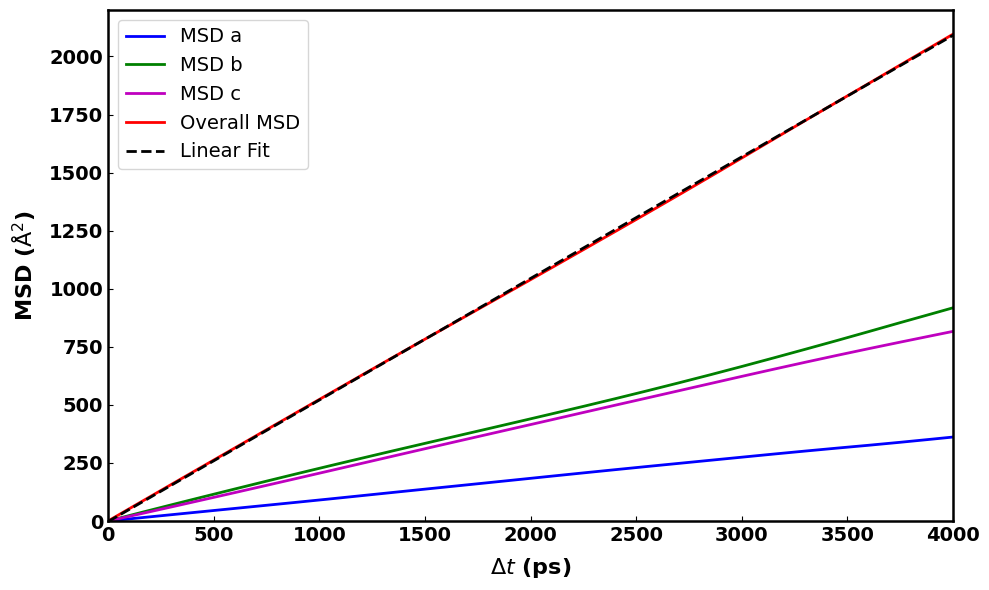

Diffusion Coefficient (Å^2/ps): 0.087255
Diffusion Coefficient (cm^2/s): 8.725519e-06


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# MSD series
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 4460, 150)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with the origin point (0, 0)
MSD_a_averages = [0]  # Start with MSD = 0 at delta_t = 0
MSD_b_averages = [0]
MSD_c_averages = [0]
MSD_t_averages = [0]

# Calculate MSD for each delta_t
for delta_t in delta_t_steps:
    msd_a_values = []  # To store MSD for each interval in msd_a
    msd_b_values = []  # To store MSD for each interval in msd_b
    msd_c_values = []  # To store MSD for each interval in msd_c
    msd_t_values = []  # To store MSD for each interval in msd_t

    # Loop through valid time windows based on delta_t
    for start_idx in range(len(msd_a) - delta_t // 150):  # 200 ps corresponds to a step size of 1 in your data
        end_idx = start_idx + delta_t // 150  # Calculate the index for delta_t

        # Ensure the indices are valid
        if end_idx < len(msd_a):
            # Calculate MSD for each series
            msd_a_values.append(msd_a.iloc[end_idx] - msd_a.iloc[start_idx])
            msd_b_values.append(msd_b.iloc[end_idx] - msd_b.iloc[start_idx])
            msd_c_values.append(msd_c.iloc[end_idx] - msd_c.iloc[start_idx])
            msd_t_values.append(msd_t.iloc[end_idx] - msd_t.iloc[start_idx])

    # Calculate the average MSD for this delta_t if valid values are found
    if msd_a_values:
        MSD_a_averages.append(np.mean(msd_a_values))
        MSD_b_averages.append(np.mean(msd_b_values))
        MSD_c_averages.append(np.mean(msd_c_values))
        MSD_t_averages.append(np.mean(msd_t_values))
        delta_t_values.append(delta_t)

# Plot MSD vs Delta t
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MSD data with continuous lines (no markers)
ax.plot(delta_t_values, MSD_a_averages, '-', label='MSD a', linewidth=2, color='b')
ax.plot(delta_t_values, MSD_b_averages, '-', label='MSD b', linewidth=2, color='g')
ax.plot(delta_t_values, MSD_c_averages, '-', label='MSD c', linewidth=2, color='m')
ax.plot(delta_t_values, MSD_t_averages, '-', label='Overall MSD', linewidth=2, color='r')

# Add a linear regression line for the overall MSD
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_t_averages)
r_squared = r_value**2
ax.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit', color='black', linewidth=2)

# Axis labels and legend
ax.set_xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(loc="upper left", fontsize=14)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')
plt.xlim(0, 4000)
plt.ylim(0, 2200)
# Show the plot
plt.tight_layout()

# Save the figure as PDF
plt.savefig("msd_vs_delta_t_all_series_300_continuous.pdf", format='pdf')
plt.savefig("msd_vs_delta_t_all_series_300_continuous.tif", format='tif')

# Display the plot
plt.show()

# Print the calculated diffusivity
print(f"Diffusion Coefficient (Å^2/ps): {slope / 6:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {slope / 6 * 1e-4:.6e}")


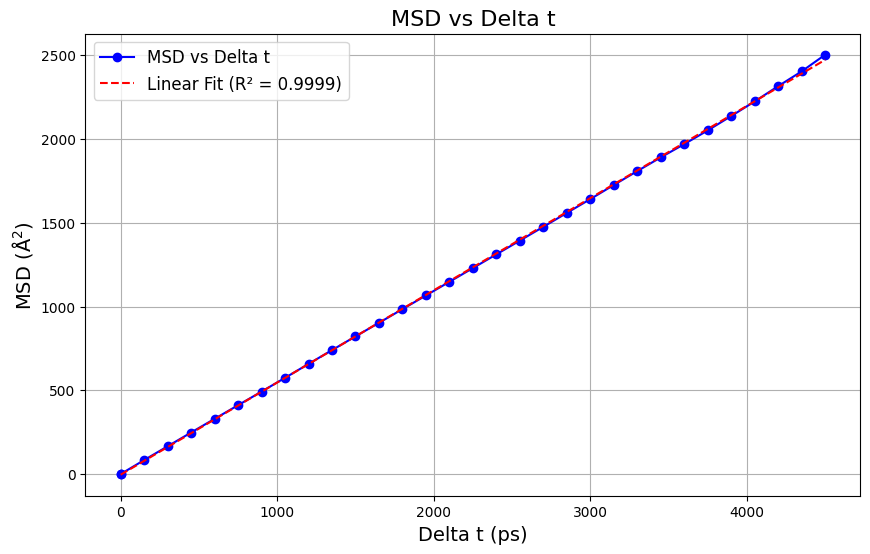

Slope: 0.550505
Intercept: -3.837600
R² Score: 0.999906
Delta t = 0 ps, Average MSD = 0.000000
Delta t = 0 ps, Average MSD = 0.000000
Delta t = 150 ps, Average MSD = 83.458528
Delta t = 300 ps, Average MSD = 165.821032
Delta t = 450 ps, Average MSD = 248.159056
Delta t = 600 ps, Average MSD = 329.635059
Delta t = 750 ps, Average MSD = 411.094091
Delta t = 900 ps, Average MSD = 492.463404
Delta t = 1050 ps, Average MSD = 574.591262
Delta t = 1200 ps, Average MSD = 657.722701
Delta t = 1350 ps, Average MSD = 740.017221
Delta t = 1500 ps, Average MSD = 821.946818
Delta t = 1650 ps, Average MSD = 902.958608
Delta t = 1800 ps, Average MSD = 984.806874
Delta t = 1950 ps, Average MSD = 1066.261273
Delta t = 2100 ps, Average MSD = 1147.929952
Delta t = 2250 ps, Average MSD = 1229.897252
Delta t = 2400 ps, Average MSD = 1311.890402
Delta t = 2550 ps, Average MSD = 1393.914942
Delta t = 2700 ps, Average MSD = 1476.361762
Delta t = 2850 ps, Average MSD = 1559.277550
Delta t = 3000 ps, Average MSD

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is your DataFrame
time_ps = msd_md['#'] / 1000  # Convert time to picoseconds
MSCD = msd_md['MSD_c']  # MSCD values

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 4650, 150)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with delta_t = 0
MSD_averages = [0]  # Start with MSD = 0 at delta_t = 0

# Loop over each delta_t value (200, 400, 600, ..., 4000)
for delta_t in delta_t_steps:
    msd_values = []  # To store MSD for each interval at delta_t
    
    # Loop over the valid time windows for each delta_t
    for start_idx in range(0, len(MSCD) - delta_t // 150):
        end_idx = start_idx + delta_t // 150
        
        if end_idx < len(MSCD):  # Ensure valid indices
            msd = MSCD.iloc[end_idx] - MSCD.iloc[start_idx]  # Calculate MSCD for this interval
            msd_values.append(msd)
    
    # Calculate the average MSD for this delta_t if valid values exist
    if msd_values:
        avg_msd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSD_averages.append(avg_msd)

# Linear regression and R² calculation
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_averages)
r_squared = r_value**2

# Now, plotting the results
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, MSD_averages, 'o-', label='MSD vs Delta t', color='blue')

# Plot the linear fit
plt.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit (R² = {r_squared:.4f})', color='red')

# Labeling the plot
plt.xlabel('Delta t (ps)', fontsize=14)
plt.ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=14)
plt.title('MSD vs Delta t', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
#plt.xlim(0, 4000)

# Show the plot
plt.show()

# Print the regression results
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R² Score: {r_squared:.6f}")

# Print the average MSD values for each delta_t
for delta_t, avg_msd in zip(delta_t_values, MSD_averages):
    print(f"Delta t = {delta_t} ps, Average MSD = {avg_msd:.6f}")


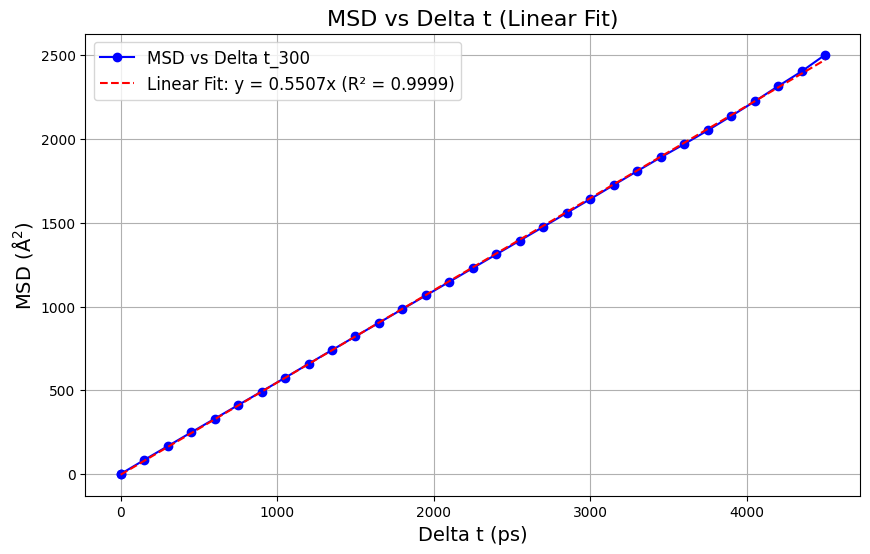

Slope (m): 0.550660
Intercept: -4.309563
R² Score: 0.999899
Results have been saved to 'msd_vs_delta_t.xlsx'.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is your DataFrame
time_ps = msd_md['#'] / 1000  # Convert time to picoseconds
MSCD = msd_md['MSD_c']  # MSCD values

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 4650, 150)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with delta_t = 0
MSD_averages = [0]  # Start with MSD = 0 at delta_t = 0

# Loop over each delta_t value (200, 400, 600, ..., 4000)
for delta_t in delta_t_steps:
    msd_values = []  # To store MSD for each interval at delta_t
    
    # Loop over the valid time windows for each delta_t
    for start_idx in range(0, len(MSCD) - delta_t // 150):
        end_idx = start_idx + delta_t // 150
        
        if end_idx < len(MSCD):  # Ensure valid indices
            msd = MSCD.iloc[end_idx] - MSCD.iloc[start_idx]  # Calculate MSCD for this interval
            msd_values.append(msd)
    
    # Calculate the average MSD for this delta_t if valid values exist
    if msd_values:
        avg_msd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSD_averages.append(avg_msd)

# Perform linear regression to find the slope (m) and intercept
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values[1:], MSD_averages[1:])

# R² score (coefficient of determination)
r_squared = r_value**2

# Now, plotting the results
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, MSD_averages, 'o-', label='MSD vs Delta t_300', color='blue')

# Plot the linear fit (y = mx)
plt.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit: y = {slope:.4f}x (R² = {r_squared:.4f})', color='red')

# Labeling the plot
plt.xlabel('Delta t (ps)', fontsize=14)
plt.ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=14)
plt.title('MSD vs Delta t (Linear Fit)', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# Print the slope (m), intercept, and R² score
print(f"Slope (m): {slope:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R² Score: {r_squared:.6f}")

# Save the MSCD and delta_t values in an Excel file
result_df = pd.DataFrame({
    'Time (ps)': delta_t_values[1:],  # Skip the first entry (0 ps)
    'MSD (Å²)': MSD_averages[1:]  # Skip the first entry (MSD = 0)
})

# Save the DataFrame to an Excel file
result_df.to_excel('msd_vs_delta_t_1200.xlsx', index=False)

print("Results have been saved to 'msd_vs_delta_t.xlsx'.")


Slope: 0.550660 Å²/ps
Final Result: 9.177662e-06 cm²/s


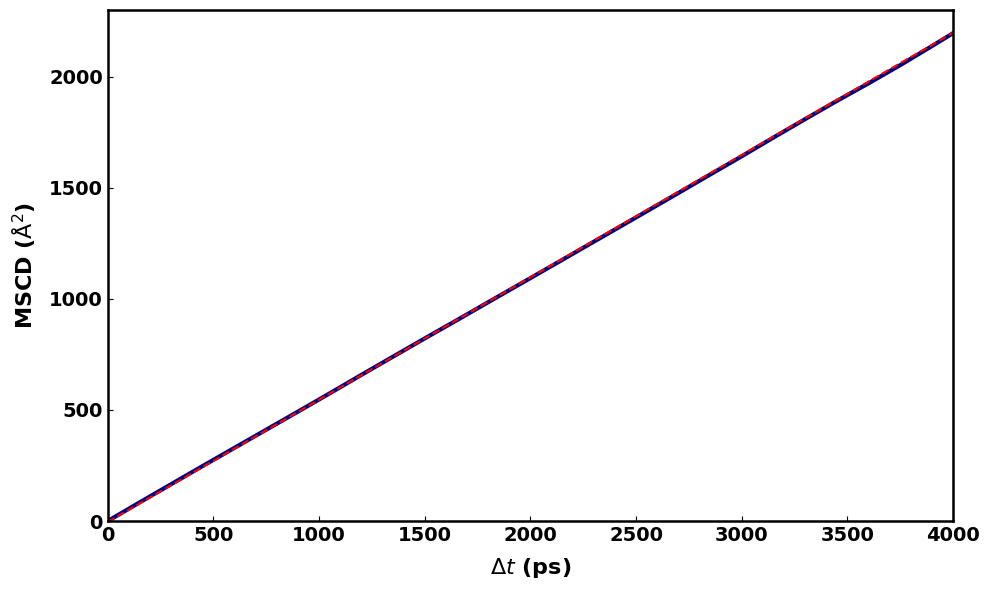

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data from the Excel file
df_mscd = pd.read_excel("msd_vs_delta_t_1200.xlsx")

# Extract the data using the correct column names
time_ps = df_mscd['Time (ps)']
MSD_values = df_mscd['MSD (Å²)']

# Perform linear regression to calculate the slope
slope, intercept, r_value, p_value, std_err = linregress(time_ps, MSD_values)

# Perform the requested operations
result = (slope / 6) * 1e-4

# Print the slope and the final result
print(f"Slope: {slope:.6f} Å²/ps")
print(f"Final Result: {result:.6e} cm²/s")

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(time_ps, MSD_values, '-', color=(0, 0, 0.5), linewidth=3)  # Deep navy blue, thicker line
plt.plot(time_ps, intercept + slope * time_ps, '--', color='red', label=f'Linear Fit: Slope = {slope:.4f}')  # Linear fit line
plt.xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Set x-axis and y-axis limits
plt.xlim(0, 4000)
plt.ylim(0, 2300)

# Save the plot as PDF
plt.tight_layout()
#plt.legend(fontsize=12)
plt.savefig("dd_mscd_30ps_with_fit.pdf", format='pdf')

# Display the plot
plt.show()


In [22]:
8.725519e-06/9.177662e-06 

0.9507344027269691